In [24]:
## Initialization
import numpy as np
import scipy.optimize as op
import matplotlib.pyplot as plt
%matplotlib inline

In [25]:
def plotData(X, y):
    # Find Indices of Positive and Negative Examples
    pos = np.where(y==1)
    neg = np.where(y==0)
    # plot! [0] indexing at end necessary for proper legend creation in ex2.py
    p1 = plt.plot(X[pos,0], X[pos,1], marker='+', markersize=9, color='k')[0]
    p2 = plt.plot(X[neg,0], X[neg,1], marker='o', markersize=7, color='y')[0]
    return plt, p1, p2

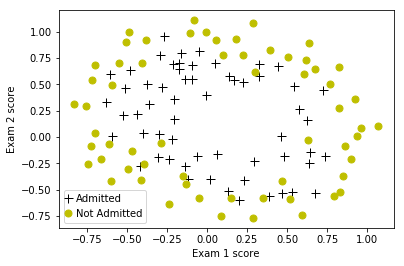

In [26]:
## Load Data
#  The first two columns contains the exam scores and the third column
#  contains the label.
data = np.loadtxt('data/ex2data2.txt', delimiter=",")
X = data[:,:2]
y = data[:,2]

plt,p1,p2 =plotData(X, y)
# # Labels and Legend
plt.xlabel('Exam 1 score')
plt.ylabel('Exam 2 score')
plt.legend((p1, p2), ('Admitted', 'Not Admitted'), numpoints=1, handlelength=0)
plt.show(block=False) # prevents having to close the graph to move forward with ex2.py

In [27]:
def mapFeature(X1, X2):
    # MAPFEATURE Feature mapping function to polynomial features
    #
    #   MAPFEATURE(X1, X2) maps the two input features
    #   to quadratic features used in the regularization exercise.
    #
    #   Returns a new feature array with more features, comprising of 
    #   X1, X2, X1.^2, X2.^2, X1*X2, X1*X2.^2, etc..
    #   for a total of 1 + 2 + ... + (degree+1) = ((degree+1) * (degree+2)) / 2 columns
    #
    #   Inputs X1, X2 must be the same size
    #

    degree = 6
    out = np.ones(( X1.shape[0], sum(range(degree + 2)) )) # could also use ((degree+1) * (degree+2)) / 2 instead of sum
    curr_column = 1
    for i in range(1, degree + 1):
        for j in range(i+1):
            out[:,curr_column] = np.power(X1,i-j) * np.power(X2,j)
            curr_column += 1
    return out

In [28]:
def sigmoid(z):
    return 1./(1+np.exp(-z))
def costFunctionReg(theta, X, y, lambda_reg, return_grad=False):
    m , n = X.shape
    y = y.reshape((m,1))
    theta = theta.reshape((n,1));
    h=sigmoid(np.dot(X,theta))
    J = 1./m * ( -np.dot(y.T , np.log(h)) - np.dot((1 - y.T),np.log (1 - h)))
    if lambda_reg!=0:
        reg = ( float(lambda_reg) / (2*m)) * np.power(theta[1:theta.shape[0]],2).sum()
        J = J+reg
    if return_grad:
        grad = 1./m * np.dot(X.T, (h - y))
        if lambda_reg!=0:
            grad_no_regularization = grad
            # applies to j = 1,2,...,n - NOT to j = 0
            grad = grad_no_regularization + ( float(lambda_reg) / m )*theta
            # the case of j = 0 (recall that grad is a n+1 vector)
            # since we already have the whole vectorized version, we use that
            # and then assign only the first element of grad_no_regularization to grad
            grad[0] = grad_no_regularization[0]
        return [J,grad.flatten()] 
    return J
def probability(theta,X):
    return sigmoid(np.dot(X , theta))
def predict(theta,X):
    return sigmoid(np.dot(X , theta))>=0.5


In [29]:
## =========== Part 1: Regularized Logistic Regression ============
#  In this part, you are given a dataset with data points that are not
#  linearly separable. However, you would still like to use logistic 
#  regression to classify the data points. 
#
#  To do so, you introduce more features to use -- in particular, you add
#  polynomial features to our data matrix (similar to polynomial
#  regression).
#

# Add Polynomial Features

# Note that mapFeature also adds a column of ones for us, so the intercept
# term is handled
X = mapFeature(X[:,0], X[:,1])
m,n = X.shape

# Initialize fitting parameters
initial_theta = np.zeros((n, 1))

# Set regularization parameter lambda to 1
lambda_reg = 0.1

# Compute and display initial cost 
# gradient is too large to display in this exercise
cost = costFunctionReg(initial_theta, X, y, lambda_reg)

print('Cost at initial theta (zeros):',cost)
# print('Gradient at initial theta (zeros):')
# print(grad)

Cost at initial theta (zeros): [[0.69314718]]


In [30]:
def plotDecisionBoundary(theta, X, y):
    plt, p1, p2 = plotData(X[:,1:3], y)
   
    if X.shape[1] <= 3:
        # Only need 2 points to define a line, so choose two endpoints
        plot_x = np.array([min(X[:,1])-2,  max(X[:,1])+2])

        # Calculate the decision boundary line
        plot_y = (-1./theta[2])*(theta[1]*plot_x + theta[0])

        # Plot, and adjust axes for better viewing
        p3 = plt.plot(plot_x, plot_y)
        
        # Legend, specific for the exercise
        plt.legend((p1, p2, p3[0]), ('Admitted', 'Not Admitted', 'Decision Boundary'), numpoints=1, handlelength=0.5)

        plt.axis([30, 100, 30, 100])

        plt.show(block=False)
    else:
        
        # Here is the grid range
        u = np.linspace(-1, 1.5, 50)
        v = np.linspace(-1, 1.5, 50)

        z = np.zeros(( len(u), len(v) ))
        # Evaluate z = theta*x over the grid
        for i in range(len(u)):
            for j in range(len(v)):
                z[i,j] = np.dot(mapFeature(np.array([u[i]]), np.array([v[j]])),theta)
        z = np.transpose(z) # important to transpose z before calling contour

        # Plot z = 0
        # Notice you need to specify the level 0
        # we get collections[0] so that we can display a legend properly
        p3 = plt.contour(u, v, z,levels=[0],cmap="Greys_r").collections[0]
        #plt.contour(u, v, z)
        # Legend, specific for the exercise
        plt.legend((p1,p2, p3),('y = 1', 'y = 0', 'Decision Boundary'), numpoints=1, handlelength=0)
        plt.xlabel('Microchip Test 1')
        plt.ylabel('Microchip Test 2')
        plt.title('lambda = {:f}'.format(lambda_reg))
        plt.show(block=False)

In [31]:
def train(lambda_reg):
    # Initialize fitting parameters
    initial_theta = np.zeros((n, 1))
    #  Run fmin_bfgs to obtain the optimal theta
    #  This function returns theta and the cost 
    theta=op.fmin_bfgs(costFunctionReg, x0=initial_theta, args=(X, y, lambda_reg))
    p = predict(theta, X)
    print('Train Accuracy: {:f}'.format(np.mean(p == y) * 100))
    plotDecisionBoundary(theta, X, y)
    

Optimization terminated successfully.
         Current function value: 0.235474
         Iterations: 542
         Function evaluations: 17670
         Gradient evaluations: 589
Train Accuracy: 88.983051


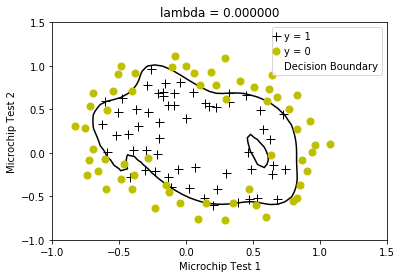

Optimization terminated successfully.
         Current function value: 0.529003
         Iterations: 47
         Function evaluations: 1440
         Gradient evaluations: 48
Train Accuracy: 83.050847


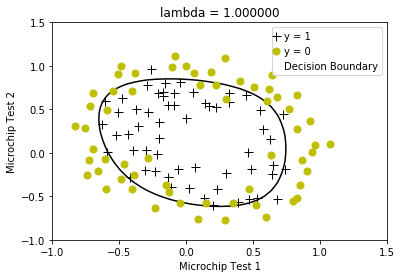

Optimization terminated successfully.
         Current function value: 0.648216
         Iterations: 21
         Function evaluations: 660
         Gradient evaluations: 22
Train Accuracy: 74.576271


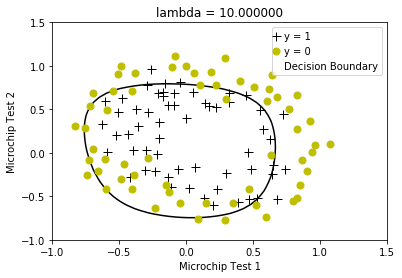

Optimization terminated successfully.
         Current function value: 0.686484
         Iterations: 7
         Function evaluations: 240
         Gradient evaluations: 8
Train Accuracy: 61.016949


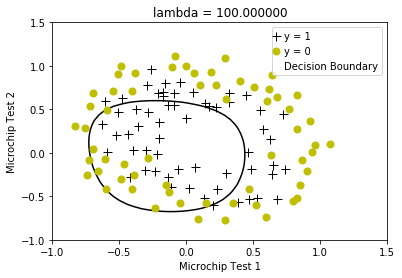

In [32]:
## ============= Part 2: Regularization and Accuracies =============
#  Optional Exercise:
#  In this part, you will get to try different values of lambda and 
#  see how regularization affects the decision coundart
#
#  Try the following values of lambda (0, 1, 10, 100).
#
#  How does the decision boundary change when you vary lambda? How does
#  the training set accuracy vary?


# Set regularization parameter lambda to 1 (you should vary this)
lambda_regs = (0, 1, 10, 100)

for lambda_reg in lambda_regs:
    train(lambda_reg)
